<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pickle

In [21]:
with open('hw4_p1.pkl', 'rb') as f:
  data = pickle.load(f)

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

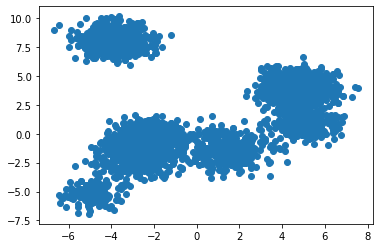

In [23]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [24]:
data.shape

(3451, 2)

In [25]:
import numpy as np

In [26]:
class Kmeans():
  def __init__(self, k=1, d=2, state=0):
    self.state = state
    self.k = k
    self.d = d
  
  def fit(self, train_data):
    assert self.d == train_data.shape[-1], 'data dim mismatch'
    
    converged = False
    np.random.seed(self.state)
    cur_cent = np.random.randn(self.k, self.d)
    dist = None
    assign = None
    while not converged:
      data = train_data[:, None, :]
      cent = cur_cent[None, :, :]
      dist = np.sum((data - cent) ** 2, axis=-1)
      assign = np.argmin(dist, axis=1)
      new_cent = []
      for i in range(len(cur_cent)):
        mask = assign == i
        points = train_data[mask, :]
        num_points = mask.sum()
        avg = points.sum(0) / num_points
        new_cent.append(avg)
      new_cent = np.stack(new_cent, axis=1).T
      if (new_cent == cur_cent).all():
        converged = True
      else:
        cur_cent = new_cent
      
    return cur_cent, dist, assign

In [27]:
model = Kmeans(k=3, d=2)

In [28]:
centroids, dist, assignment = model.fit(data)

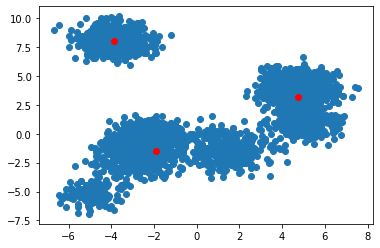

In [29]:
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r')
plt.show()

### Elbow Method

In [30]:
def compute_wss(dist):
  return np.sum(np.amin(dist, axis=1))

In [31]:
wss_k = []
for k in range(2, 13):
  model = Kmeans(k=k, d=2)
  centroids, dist, assignment = model.fit(data)
  wss = compute_wss(dist)
  wss_k.append(wss)

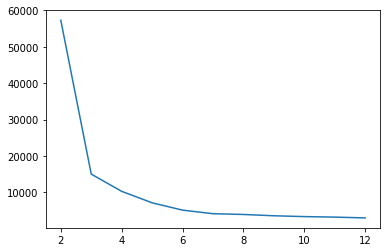

In [32]:
plt.plot(range(2, 13), wss_k)
plt.show()

### Silhouette Method

In [33]:
def compute_silhouette_score(data, assignment):
  num_cluster = len(np.unique(assignment))
  s_scores = []
  for i, point in enumerate(data):
    cluster = assignment[i]
    mask = assignment == cluster
    cluster_points = data[mask, :]
    
    a = np.sqrt(((cluster_points - point) ** 2).sum(1)).sum() / (len(cluster_points)  - 1)

    outer_dist = []
    for j in range(num_cluster):
      if j != cluster:
        outer_cluster_points = data[assignment == j, :]
        outer_avg_dist = np.sqrt(((outer_cluster_points - point) ** 2).sum(1)).mean()
        outer_dist.append(outer_avg_dist)
    
    assert len(outer_dist) == num_cluster - 1, len(outer_dist)
    b = min(outer_dist)

    score = (b - a) / max(b, a)
    s_scores.append(score)

  return np.array(s_scores)

In [34]:
silhouette_k = []
for k in range(2, 13):
  model = Kmeans(k=k, d=2)
  centroids, dist, assignment = model.fit(data)
  s_score = compute_silhouette_score(data, assignment).mean()
  silhouette_k .append(s_score)

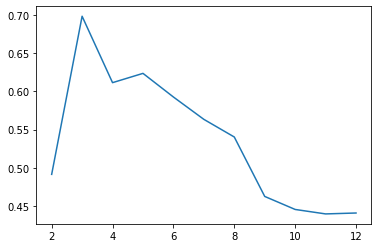

In [35]:
plt.plot(range(2, 13),silhouette_k)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4915156382141334
For n_clusters = 3 The average silhouette_score is : 0.6979536004537619
For n_clusters = 4 The average silhouette_score is : 0.6112523297845172
For n_clusters = 5 The average silhouette_score is : 0.6233703515511063
For n_clusters = 6 The average silhouette_score is : 0.5925197965202162
For n_clusters = 7 The average silhouette_score is : 0.5633399075735237
For n_clusters = 8 The average silhouette_score is : 0.5403011481796185


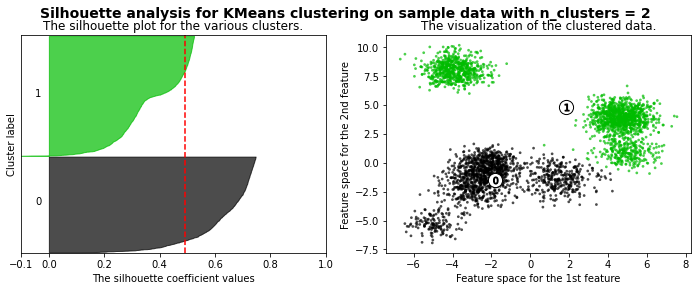

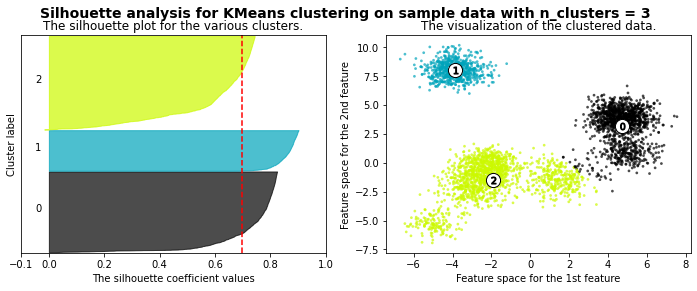

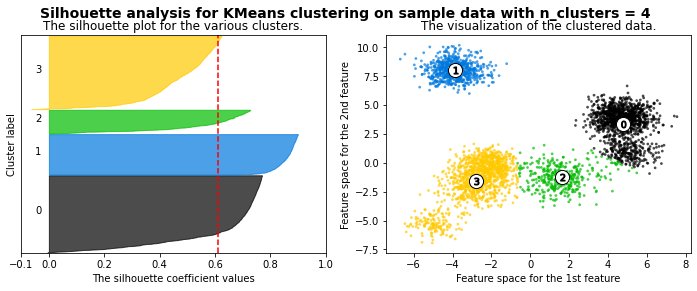

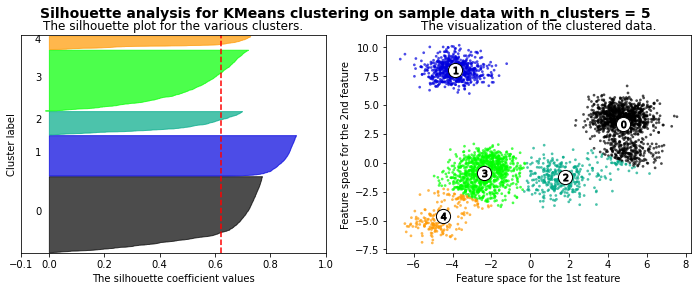

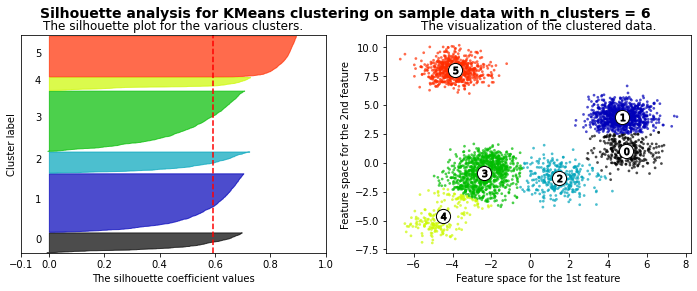

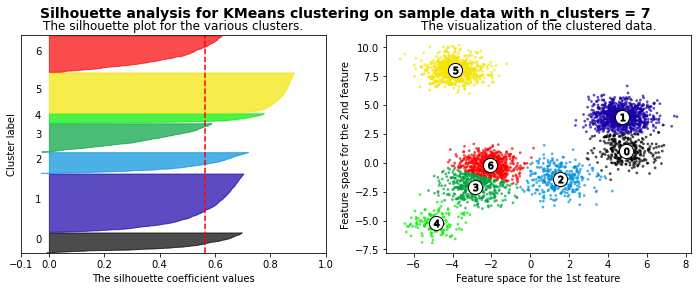

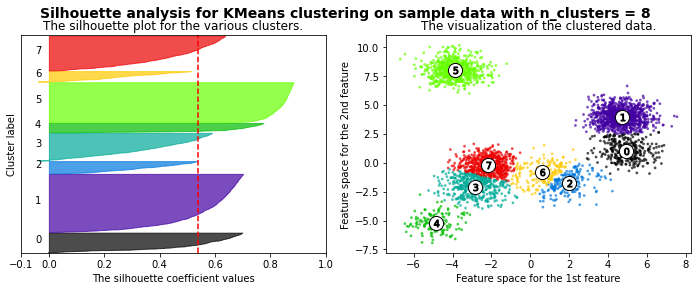

In [36]:
'''
the following code is taken from 
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
'''

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    model = Kmeans(k=n_clusters)
    centers, dist, cluster_labels = model.fit(data)

    silhouette_avg = compute_silhouette_score(data, cluster_labels).mean()
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = compute_silhouette_score(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Both Elbow's method and Silhouette Method suggest that the optimal k = 3